# CS-141 Homework 2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

# Autosave work 
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [ ]:
# Functions that can move the drone and particles
# Generate random movement in the x and y direction

def random_movement():
    """ Generates a random movement vector in the x and y direction, 
    such that dx^2 + dy^2 = 1.0
    Inputs: none
    Outputs: dx, dy
    """
    dx = np.random.uniform(-1, 1)
    posneg = np.random.choice([-1, 1])
    dy = (np.sqrt(1-dx**2))*posneg
    return dx,dy

def move_drone(pos,map, sigma_movement = 5):
    """ 
    Moves the drone a random distance dx, dy
    while checking to make sure it is in range of the map
    Inputs: Previous position, map
    OUtputs: new position 
    """
    dx,dy = random_movement()
    m = 100
    # print(dx)
    # print(dy)
    move_x = int(np.floor(dx*50)) + np.random.randn()*sigma_movement
    move_y = int(np.floor(dy*50)) + np.random.randn()*sigma_movement
    new_pos = pos + np.array([[move_x],[move_y]])

    while new_pos[0]+m/2 > (map.shape[1]) or new_pos[1]+m/2 > (map.shape[0]) or new_pos[0]-m/2 < (0) or new_pos[1]-m/2 < (0):
        print("Movement rejected, generating a new movement")
        dx,dy = random_movement()
        move_x = int(np.floor(dx*50)) + sigma_movement
        move_y = int(np.floor(dy*50)) + sigma_movement
        new_pos = pos + np.array([[move_x],[move_y]])
        # print(new_pos)

    return new_pos,dx,dy

def move_particle(pos,map, dx, dy, sigma_particle = 3):
    """ 
    Moves the drone a random distance dx, dy
    while checking to make sure it is in range of the map
    Inputs: Previous position, map
    OUtputs: new position 
    """
    # print(pos)
    move_x = int(np.floor(dx*50))
    # print(move_x)
    move_y = int(np.floor(dy*50))
    # print(move_y)
    new_pos = pos + np.array([[move_x],[move_y]])
    # print(new_pos)

    return new_pos

def im_comp(ref,particle,m):
    """ 
    Compares the view from a particle and compares 
    it to a reference image
    Inputs: Reference image, particle, pixels in each direction (m)
    Outputs: error associated with that particle
    Using ABSOLUTE ERROR APPROACH 
    """
    max_error = 10000000
    x = int(particle[0])
    y = int(particle[1])
    par_im = map[y:y+m,x:x+m]
    # Check if the extracted image has the required shape
    if par_im.shape != (100, 100, 3):
        # par_im = cv2.resize(par_im, (100, 100))
        return max_error  # Assign max error if shape is incorrect
        
    diff = cv2.absdiff(ref, par_im) # Absolute difference
    error = np.sum(diff) # Sum errors 
    
    return error

def low_variance_sampler(particles, weights):
    """
    Low variance resampling based on the particle weights.
    Parameters:
    particles (numpy.ndarray): Array of particle positions (N x 3)
    weights (numpy.ndarray): Normalized weights associated with each particle
    Returns:
    numpy.ndarray: Resampled array of particles
    FROM TEXTBOOK: Thrun, Burgard, Fox, page 86
    """
    N = len(particles)
    new_particles = np.zeros_like(particles)
    cumulative_sum = np.cumsum(weights)
    # print(cumulative_sum)
    
    # Start uniformly between 0 and 1/N
    start = np.random.uniform(0, 1 / N)
    index = 0  # Index of particles
    
    # Low variance saEmpling loop
    for i in range(N):
        u = start + i * (1 / N)
        while u > cumulative_sum[index]:
            index += 1
        new_particles[i] = particles[index]
        
    return new_particles

def GetScanRelation(BinsPerChannel, ref, particle):
    """ 
    Generates a 3D color histogram comparison of the reference image and particle image.
    
    Inputs: BinsPerChannel: Number of bins per channel for histogram calculation
        ref: Reference image
        particle: Particle position as an array containing (x, y)
    
    Output: Correlation score between the reference and particle image histogram
    """
    # Extract particle position
    x = int(particle[0])
    y = int(particle[1])
    
    # Define the size of the patch to extract
    m = 100  # Size of the patch (100x100)
    
    # Ensure the extracted area is within bounds
    if (y >= m // 2 and y <= map.shape[0] - m // 2) and (x >= m // 2 and x <= map.shape[1] - m // 2):
        # Extract the image patch from the map
        par_im = map[y - m // 2:y + m // 2, x - m // 2:x + m // 2]
        # print("PAR IMAGE", par_im)
        # print("\n REF \n", ref)
        # Calculate histograms
        histref = cv2.calcHist([ref], [0, 1, 2], None, [BinsPerChannel, BinsPerChannel, BinsPerChannel],
                                [0, 256, 0, 256, 0, 256])
        histp = cv2.calcHist([par_im], [0, 1, 2], None, [BinsPerChannel, BinsPerChannel, BinsPerChannel],
                              [0, 256, 0, 256, 0, 256])

        # Normalize histograms
        histref = cv2.normalize(histref, histref).flatten()
        histp = cv2.normalize(histp, histp).flatten()

        # Return the correlation between the two histograms
        return cv2.compareHist(histref, histp, cv2.HISTCMP_CORREL)
    else:
        # If the particle position is out of bounds, return a default value (e.g., 0 or max correlation)
        return 0

def abs_avg_dev(pos_arr, drone_pos):
    """ 
    Calculates the absolute average deviation of a pos array of particle 
    Inputs: Array of particle positions, drone position 
    Outputs: absolute average deviation 
    """
    absdev = 0
    N = len(pos_arr)
    for i in range(N):
        p = pos_arr[i,1:].reshape(2,1)
        # print(p)
        # print(drone_pos)
        x_dif = p[0] - drone_pos[0]
        y_dif = p[1] - drone_pos[1]
        dev = np.sqrt(x_dif**2 + y_dif**2)
        dev_w = 1/N * dev
        absdev += dev_w
        
    return absdev
        
        



The range in the x and y directions is (11,8) units

Trial 0 for m = 100


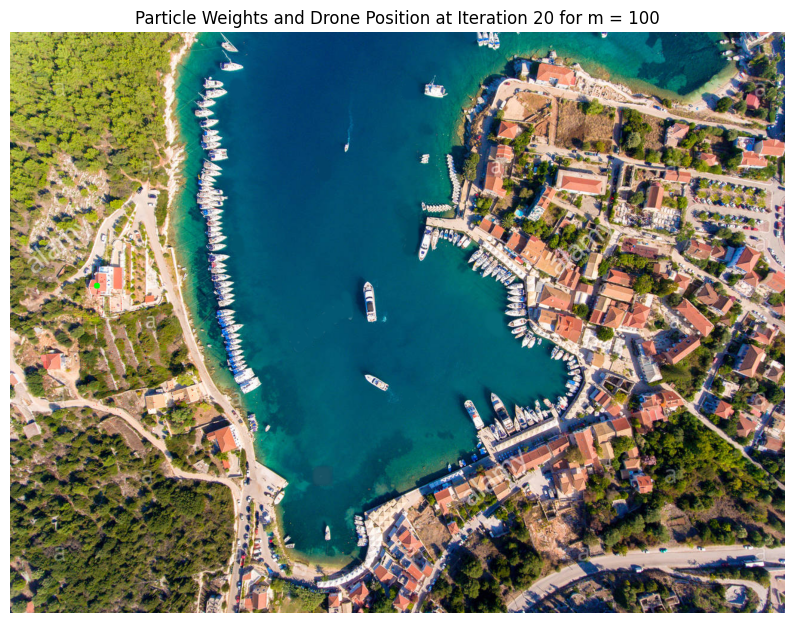

Trial 0 for m = 150


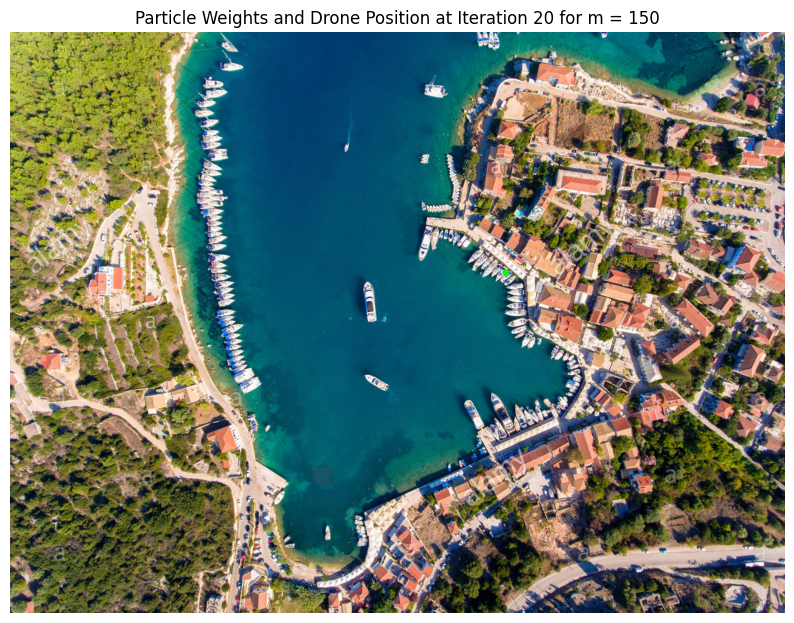

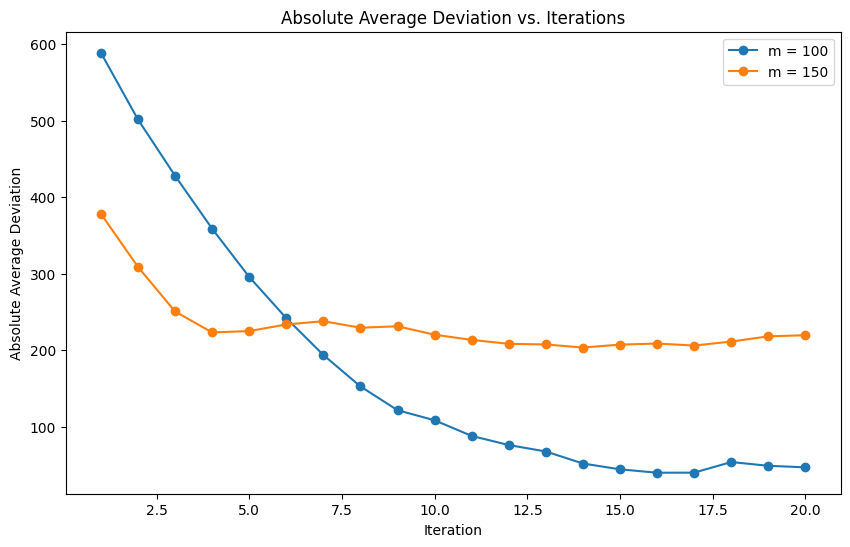

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image map of choice
map_orig = cv2.imread('BayMap.png')
# Alternative maps
# map_orig = cv2.imread('CityMap.png')
# map_orig = cv2.imread('MarioMap.png')

map_orig = cv2.cvtColor(map_orig, cv2.COLOR_BGR2RGB)
map = map_orig.copy()

# Parameters
trials = 1
iterations = 20
m_values = [100, 150]
dFOV = 100  # Field of view of the drone
sigma_movement = 5  # Movement from wind

# Calculate the range in the x and y directions
range_x = ((map.shape[1] - dFOV) // 2) // 50
range_y = ((map.shape[0] - dFOV) // 2) // 50
print(f'\nThe range in the x and y directions is ({range_x},{range_y}) units\n')

# Collect deviations for each value of m
devs_dict = {m_val: [] for m_val in m_values}

for m in m_values:
    for trial in range(trials):
        print(f"Trial {trial} for m = {m}")
        
        # Re-initialize variables that depend on m
        map = map_orig.copy()
        hal = int(m / 2)

        # Simulate a drone's starting position x and y
        pos_x = np.random.randint(-range_x, range_x + 1)
        pos_y = np.random.randint(-range_y, range_y + 1)
        center_x = int(pos_x * 50 + (map.shape[1] // 2))
        center_y = int((range_y + 1 - pos_y) * 50)
        
        ref_pos_pic = map[center_y - hal:center_y + hal, center_x - hal:center_x + hal]
        ref_pos = np.array([[center_x], [center_y]])

        # Initialize particles
        N = 100  # Number of particles (N*N)
        particlePosArr = np.zeros([N**2, 3])  # particle number, xpos, ypos
        for particleCount in range(N**2):
            # Random x and y positions within the map, adjusted to stay within the FOV
            x_pos = np.random.uniform(0, map.shape[1])
            y_pos = np.random.uniform(0, map.shape[0])
            particlePosArr[particleCount, :] = [particleCount, x_pos, y_pos]

        # Track deviations over iterations for this trial
        devs = np.array([])

        for i in range(iterations):
            errors = []
            # First, create an image for each particle 
            for p in range(len(particlePosArr)):
                particle = particlePosArr[p, 1:]
                error = GetScanRelation(BinsPerChannel, ref_pos_pic, particle)
                error = error**2
                errors.append(error)

            # Normalize weights
            weights = np.array(errors)
            weights_n = weights / np.sum(weights)

            # Resample using low variance sampler
            particlePosArr = low_variance_sampler(particlePosArr, weights_n)

            # Move particles and reference image
            new_pos_drone, dx, dy = move_drone(ref_pos, map, sigma_movement=sigma_movement)
            ref_pos = new_pos_drone
            ref_pos_pic = map[center_y - hal:center_y + hal, center_x - hal:center_x + hal]

            # Update particle positions based on movement
            for k in range(len(particlePosArr)):
                p = particlePosArr[k, 1:].reshape(2, 1)
                new_pose_p = move_particle(p, map, dx, dy, sigma_particle=3)
                particlePosArr[k, 1:] = new_pose_p.reshape(1, 2)

            # Calculate absolute average deviation
            absdev = abs_avg_dev(particlePosArr, ref_pos)
            devs = np.append(devs, absdev)

            # Plot weighted particles and reference position on the 20th iteration
            if i == iterations - 1:
                # Create a copy of the map for drawing
                map_with_particles = map.copy()

                # Draw weighted particles as circles on the map
                for p in range(len(particlePosArr)):
                    particle = particlePosArr[p, 1:].astype(int)
                    weight = weights_n[p]
                    radius = int(weight * 50)  # Scale radius proportionally to weight
                    # Draw the circle on the map
                    cv2.circle(map_with_particles, (particle[0], particle[1]), radius*10, (255, 0, 0), -1)

                # Draw the drone position
                drone_pos = ref_pos.astype(int)
                cv2.circle(map_with_particles, (drone_pos[0][0], drone_pos[1][0]), 5, (0, 255, 0), -1)

                # Display the resulting map with particles and drone position
                plt.figure(figsize=(10, 10))
                plt.imshow(map_with_particles)
                plt.title(f"Particle Weights and Drone Position at Iteration {iterations} for m = {m}")
                plt.axis('off')  # Hide axes
                plt.show()

        # Store deviations for this trial
        devs_dict[m].append(devs)

# Plotting the average absolute deviation over iterations for each m
plt.figure(figsize=(10, 6))
for m, all_devs in devs_dict.items():
    avg_devs = np.mean(all_devs, axis=0)
    plt.plot(range(1, iterations + 1), avg_devs, marker='o', linestyle='-', label=f'm = {m}')

# Final plot setup
plt.xlabel("Iteration")
plt.ylabel("Absolute Average Deviation")
plt.title("Absolute Average Deviation vs. Iterations")
plt.legend()
plt.grid(False)
plt.show()


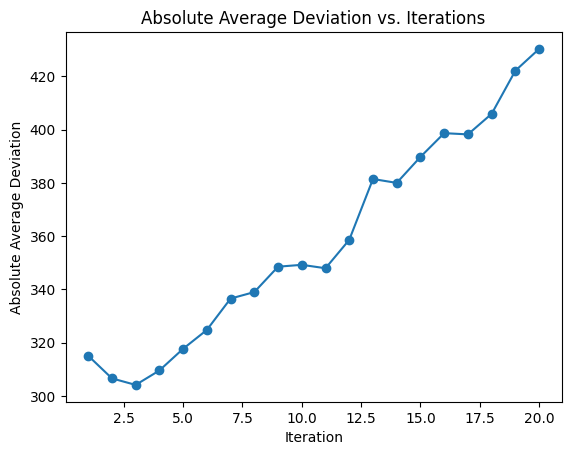

In [13]:
# Plot absolute average deviation vs iterations
plt.plot(range(1, iterations + 1), devs, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Absolute Average Deviation")
plt.title("Absolute Average Deviation vs. Iterations")
plt.grid(False)
plt.show()